In [1]:
%cd ..

c:\Code\Motor-Execution-Classifiaction


In [2]:
import pandas as pd
import numpy as np

import os

import mne
import numpy as np
import pandas as pd

from config.arms_offline import config

%matplotlib qt

In [3]:
subject = 'Viktor'
session = 'session_01'

In [23]:
def loadData(subject, session, tmin=5):
    """
    Load the numpy session
    and convert it to mne dataset
    """
    path = os.path.join(config.data_path, subject, session, "data.npy")
    test = np.load(path)
    EEG = test[2:]
    EEG.shape
    EEG /= 1000 * 1000  # (µV->V) #for Unicorn
    test[2:] = EEG

    sfreq = 250

    ch_names = [
        "STIM",
        "Fz",
        "C3",
        "Cz",
        "C4",
        "Pz",
        "PO7",
        "Oz",
        "PO8",
    ]  # documentation
    #ch_names = ["STIM", "Fp1", "FC1", "FC2", "FCz", "CPz", "CP1", "CP2", "Pz"] # API
    #ch_names = ["STIM","T7","C5", "C3", "C1", "C2","C4","C6","T8"]

    info = mne.create_info(ch_names=ch_names, sfreq=sfreq)

    raw = mne.io.RawArray(test[1:10], info)  # Drop timestamp channel

    raw.crop(tmin=tmin)

    for ch in info.ch_names:
        if ch == "STIM":
            raw.set_channel_types({ch: "stim"})
        else:
            raw.set_channel_types({ch: "eeg"})
    raw.set_montage("standard_1020")

    raw.describe()

    return raw


def filter(data):
    if config.bandpass:
        data = data.filter(
            config.bandpass_freq[0], config.bandpass_freq[1], fir_design="firwin"
        )
    if config.notch:
        data = data.notch_filter(config.notch_freq)


def create_epochs(data):
    event_dict = {"Rest": 1, "Left": 2, "Right": 3}  # ,'EndOfEvent': 10}
    mapping = {1: "Rest", 2: "Left", 3: "Right"}  # , 10:'EndOfEvent'}
    events = mne.find_events(data, stim_channel="STIM")
    annot_from_events = mne.annotations_from_events(
        events=events, event_desc=mapping, sfreq=data.info["sfreq"]
    )
    data.set_annotations(annot_from_events)
    data.drop_channels(["STIM"])
    return mne.Epochs(
        data, events, tmin=-0.5, tmax=1.5, event_id=event_dict, preload=True
    )


In [24]:
raw_data = loadData(subject, session, config.relax_time)
raw_data.describe()

Creating RawArray with float64 data, n_channels=9, n_times=55575
    Range : 0 ... 55574 =      0.000 ...   222.296 secs
Ready.
<RawArray | 9 x 53075 (212.3 s), ~3.7 MB, data loaded>
ch  name  type  unit        min         Q1     median         Q3        max
 0  STIM  STIM  NA         0.00       0.00       0.00       0.00      10.00
 1  Fz    EEG   µV    184507.22  184879.61  185071.64  185327.89  186748.30
 2  C3    EEG   µV    174856.00  175403.89  175592.09  175815.56  176406.41
 3  Cz    EEG   µV    243629.56  252282.32  264011.12  283858.36  369878.28
 4  C4    EEG   µV    250289.66  258677.11  269456.28  286778.44  349281.69
 5  Pz    EEG   µV    182548.50  184775.04  186031.16  187919.48  195288.91
 6  PO7   EEG   µV    183387.84  184402.66  185406.56  186175.16  186837.25
 7  Oz    EEG   µV    180728.97  181584.16  182018.41  182473.80  183998.94
 8  PO8   EEG   µV    183675.83  184283.80  184534.77  184766.95  185179.03
<RawArray | 9 x 53075 (212.3 s), ~3.7 MB, data loaded>
ch

C:\Users\Nemes\AppData\Local\Temp\ipykernel_17416\4239287128.py:39: RuntimeWarning: The unit for channel(s) Fz has changed from NA to V.
  raw.set_channel_types({ch: "eeg"})
C:\Users\Nemes\AppData\Local\Temp\ipykernel_17416\4239287128.py:39: RuntimeWarning: The unit for channel(s) C3 has changed from NA to V.
  raw.set_channel_types({ch: "eeg"})
C:\Users\Nemes\AppData\Local\Temp\ipykernel_17416\4239287128.py:39: RuntimeWarning: The unit for channel(s) Cz has changed from NA to V.
  raw.set_channel_types({ch: "eeg"})
C:\Users\Nemes\AppData\Local\Temp\ipykernel_17416\4239287128.py:39: RuntimeWarning: The unit for channel(s) C4 has changed from NA to V.
  raw.set_channel_types({ch: "eeg"})
C:\Users\Nemes\AppData\Local\Temp\ipykernel_17416\4239287128.py:39: RuntimeWarning: The unit for channel(s) Pz has changed from NA to V.
  raw.set_channel_types({ch: "eeg"})
C:\Users\Nemes\AppData\Local\Temp\ipykernel_17416\4239287128.py:39: RuntimeWarning: The unit for channel(s) PO7 has changed from N

In [25]:
filtered_data = raw_data.copy()
filter(filtered_data)
filtered_data.describe()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 255 samples (1.020 sec)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


In [26]:
raw_motor_data = raw_data.copy()
raw_motor_data.drop_channels(["Fz", "Cz", "Pz", "PO7", "Oz", "PO8"])


<RawArray | 3 x 53075 (212.3 s), ~1.2 MB, data loaded>

In [27]:
filtered_motor_data = filtered_data.copy()
filtered_motor_data.drop_channels(["Fz", "Cz", "Pz", "PO7", "Oz", "PO8"])

<RawArray | 3 x 53075 (212.3 s), ~1.2 MB, data loaded>

Setting up band-pass filter from 4 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 20.00 Hz: -6.02, -6.02 dB



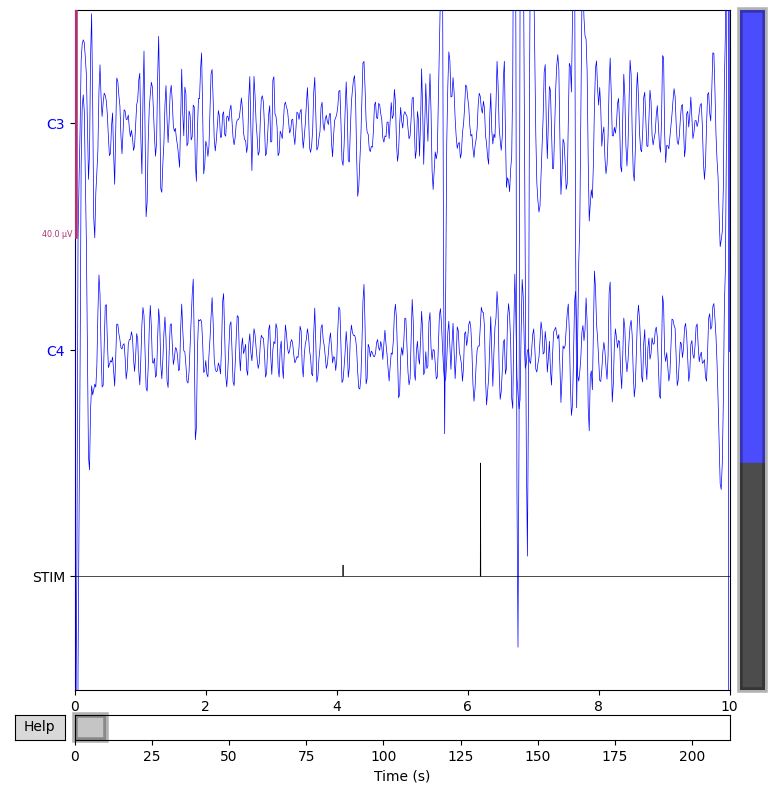

In [28]:
mne.viz.plot_raw(
    raw_motor_data, color=dict(eeg='b'),remove_dc=True, show_options=True, highpass=4.0, lowpass=20.0
)


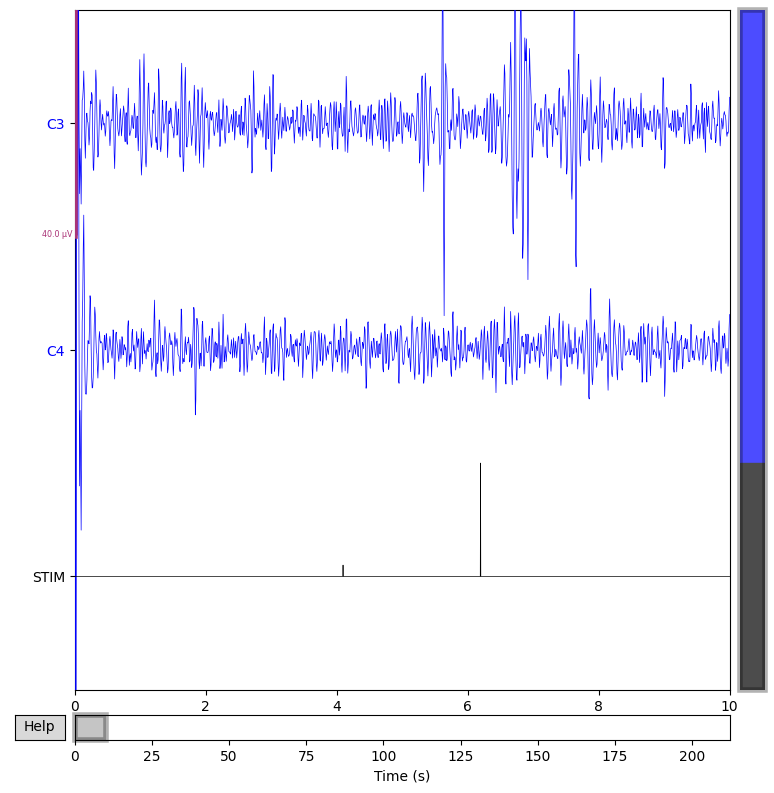

In [29]:
mne.viz.plot_raw(
    filtered_motor_data, color=dict(eeg='b'),
)


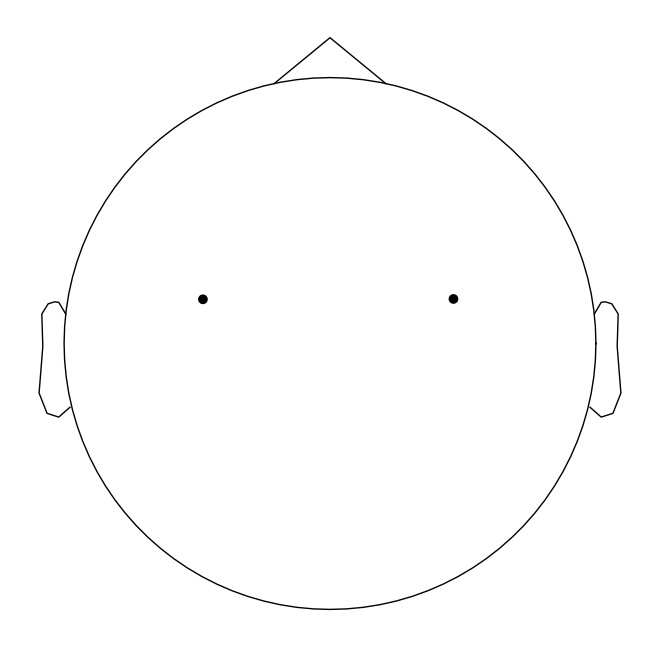

In [30]:
raw_motor_data.plot_sensors()

In [31]:
epochs = create_epochs(filtered_motor_data)

60 events found
Event IDs: [ 1  2  3 10]
Not setting metadata
30 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 501 original time points ...
0 bad epochs dropped


C:\Users\Nemes\AppData\Local\Temp\ipykernel_17416\4239287128.py:63: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  data.set_annotations(annot_from_events)


    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


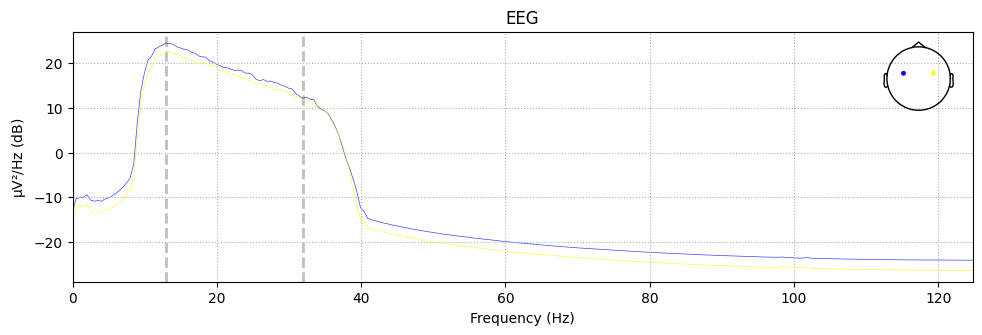

In [32]:
epochs['Left'].compute_psd().plot(picks='eeg')

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


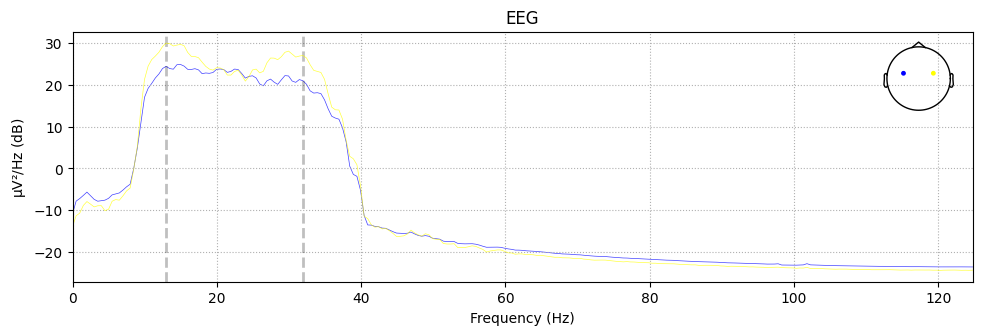

In [33]:
epochs['Right'].compute_psd().plot(picks='eeg')

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


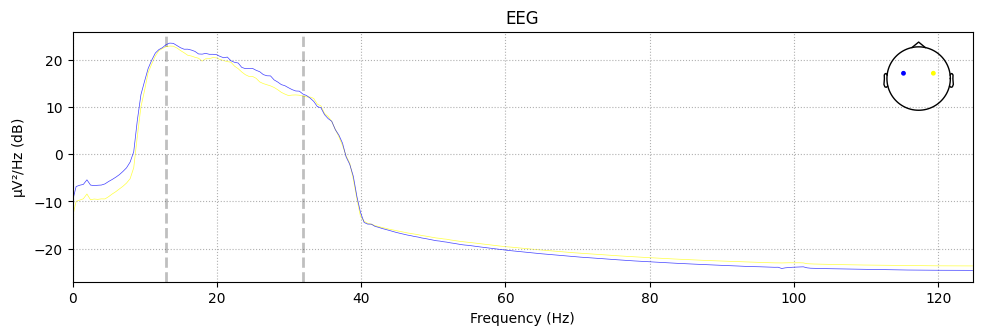

In [34]:
epochs['Rest'].compute_psd().plot(picks='eeg')

In [35]:
epochs['Left'].plot_image()

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


[<Figure size 640x480 with 3 Axes>]

Channels marked as bad:
none
Channels marked as bad:
none


In [17]:
epochs['Right'].plot_image()

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


[<Figure size 640x480 with 3 Axes>]

In [18]:
epochs['Rest'].plot_image()

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


[<Figure size 640x480 with 3 Axes>]

In [36]:
right_evoked = epochs['Right'].average()
left_evoked = epochs['Left'].average()
rest_evoked = epochs['Rest'].average()

mne.viz.plot_compare_evokeds(dict(left=left_evoked, right=right_evoked, rest=rest_evoked),
                             legend='upper left', show_sensors='upper right')


combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


[<Figure size 800x600 with 2 Axes>]

In [37]:
right_evoked.plot_joint(picks='eeg')
right_evoked.plot_topomap(times=[0., 0.5, 1.0, 1.5, 2.0], ch_type='eeg')

No projector specified for this dataset. Please consider the method self.add_proj.


ValueError: Times should be between -0.5 and 1.5.

In [38]:
left_evoked.plot_joint(picks='eeg')
left_evoked.plot_topomap(times=[0., 0.5, 1.0, 1.5, 2.0], ch_type='eeg')

No projector specified for this dataset. Please consider the method self.add_proj.


ValueError: Times should be between -0.5 and 1.5.

In [39]:
rest_evoked.plot_joint(picks='eeg')
rest_evoked.plot_topomap(times=[0., 0.5, 1.0, 1.5, 2.0], ch_type='eeg')

No projector specified for this dataset. Please consider the method self.add_proj.


ValueError: Times should be between -0.5 and 1.5.

In [40]:
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]

In [48]:
frequency_map = list()

for band, fmin, fmax in iter_freqs:
    # (re)load the data to save memory
    raw =(raw_motor_data)


    # bandpass filter
    raw.filter(fmin, fmax, n_jobs=None,  # use more jobs to speed up.
               l_trans_bandwidth=1,  # make sure filter params are the same
               h_trans_bandwidth=1)  # in each band and skip "auto" option.

    # epoch
    epochs = mne.Epochs(raw, filtered_events, event_id, tmin, tmax, baseline=baseline,
                        reject=dict(grad=4000e-13, eog=350e-6),
                        preload=True)
    # remove evoked response
    epochs.subtract_evoked()

    # get analytic signal (envelope)
    epochs.apply_hilbert(envelope=True)
    frequency_map.append(((band, fmin, fmax), epochs.average()))

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


NameError: name 'events' is not defined

In [46]:
from matplotlib import pyplot as plt
# Helper function for plotting spread
from mne.baseline import rescale
from mne.datasets import somato
from mne.stats import bootstrap_confidence_interval


def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x ** 2, axis=0)


# Plot
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.colormaps['winter_r'](np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(average.data, random_state=0,
                                                  stat_fun=stat_fun)
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(-1000, 3000)

axes.ravel()[-1].set_xlabel('Time [ms]')

Text(0.5, 0, 'Time [ms]')